In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
# import transformers
# nltk.download('punkt')
# nltk.download('stopwords')
stop = stopwords.words('english')
import re
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
all_wines = pd.read_csv('Data/winemag-data-130k-v2.csv')
all_wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
clean_wines = all_wines.drop(columns=['Unnamed: 0', 'taster_twitter_handle', 'region_2'])
clean_wines = clean_wines.dropna()
clean_wines.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [4]:
clean_wines['variety'] = clean_wines['variety'].replace(['Weissburgunder'], 'Chardonnay')
clean_wines['variety'] = clean_wines['variety'].replace(['Spatburgunder'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Grauburgunder'], 'Pinot Gris')
clean_wines['variety'] = clean_wines['variety'].replace(['Garnacha'], 'Grenache')
clean_wines['variety'] = clean_wines['variety'].replace(['Pinot Nero'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Alvarinho'], 'Albarino')

In [5]:
clean_wines['vintage'] = clean_wines['title'].str.extract('(\d\d\d\d)', expand=True)
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013


In [6]:
clean_wines['type'] = ['white' if x in ['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Sparkling Blend', 'Pinot Gris',
                                        'Champagne Blend', 'GrÃ¼ner Veltliner', 'Pinot Grigio', 'Portuguese White', 'Viognier',
                                        'GewÃ¼rztraminer', 'GewÃ¼rztraminer'] else 'red' for x in clean_wines['variety']]
clean_wines


,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red


In [7]:
clean_wines['word_count'] = clean_wines['description'].str.lower().str.split().str.len()
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43


In [8]:
clean_wines = clean_wines[clean_wines['vintage'].notna()]
clean_wines = clean_wines.copy()
clean_wines['vintage'] = clean_wines['vintage'].astype(int)
clean_wines['age'] = 2020 - clean_wines['vintage'] 
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7


In [9]:
clean_wines = clean_wines.drop_duplicates('description')
clean_wines = clean_wines[pd.notnull(clean_wines.price)]

In [10]:
clean_wines.quantile(q=0.75, axis=0, numeric_only=True)

points          91.0
price           49.0
vintage       2014.0
word_count      49.0
age             10.0
Name: 0.75, dtype: float64

<AxesSubplot:>

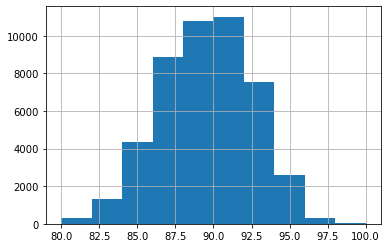

In [11]:
clean_wines['points'].hist()

In [12]:
clean_wines['good_meh'] = clean_wines['points'].apply(lambda x: 'good' if x >= 88 else 'meh')
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_meh
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7,meh
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8,meh
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9,meh
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7,meh
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8,meh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,good
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,good
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,good
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,good


In [13]:
clean_wines['grade'] = clean_wines['points'].apply(lambda x: '4' if x >= 92 else
                                                             '3' if x >= 89 else
                                                             '2' if x >= 86 else
                                                             '1')
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_meh,grade
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7,meh,2
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8,meh,2
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9,meh,2
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7,meh,2
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8,meh,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,good,3
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,good,3
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,good,3
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,good,3


In [ ]:
good_wines = clean_wines[clean_wines['good_meh'] == 'good']
good_wines

In [14]:
clean_wines['char_count'] = clean_wines["description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
clean_wines['sentence_count'] = clean_wines["description"].apply(lambda x: len(str(x).split(".")))
clean_wines['avg_word_length'] = clean_wines['char_count'] / clean_wines['word_count']
clean_wines['avg_sentence_lenght'] = clean_wines['word_count'] / clean_wines['sentence_count']
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,vintage,type,word_count,age,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,...,2013,white,33,7,meh,2,167,3,5.060606,11.000000
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,...,2012,red,41,8,meh,2,209,3,5.097561,13.666667
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,...,2011,red,42,9,meh,2,220,4,5.238095,10.500000
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,...,2013,red,31,7,meh,2,151,3,4.870968,10.333333
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,...,2012,white,30,8,meh,2,131,4,4.366667,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,...,2010,white,52,10,good,3,237,5,4.557692,10.400000
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,...,2012,red,37,8,good,3,184,4,4.972973,9.250000
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,...,2013,white,32,7,good,3,180,3,5.625000,10.666667
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,...,2013,red,43,7,good,3,183,4,4.255814,10.750000


In [15]:
winery_counts = {'winery' : clean_wines['winery'].unique(), 
                 'winery_count' : clean_wines['winery'].value_counts() 

            }
winery_df = pd.DataFrame(data=winery_counts)
winery_df.reset_index(drop=True, inplace=True)
winery_df

,winery,winery_count
0,St. Julian,144
1,Sweet Cheeks,117
2,Tandem,103
3,Terre di Giurfo,100
4,Jean-Baptiste Adam,90
...,...,...
8286,Yacochuya,1
8287,Tollot Beaut et Fils,1
8288,Bottega,1
8289,Bodegas Eidosela,1


In [16]:
clean_wines = clean_wines.merge(winery_df, how='inner', on='winery')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,type,word_count,age,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count
18699,Argentina,"Lemon rind and prune are the primary aromas, b...",Catena Alta,90,55.0,Mendoza Province,Mendoza,Michael Schachner,Bodega Catena Zapata 2006 Catena Alta Cabernet...,Cabernet Sauvignon,...,red,61,14,good,3,287,6,4.704918,10.166667,9
20757,US,"Aromas of cedar and damp soil lend a clean, fo...",Reserve,88,70.0,New York,North Fork of Long Island,Anna Lee C. Iijima,Pellegrini Vineyards 2005 Reserve Red (North F...,Bordeaux-style Red Blend,...,red,37,15,good,2,201,3,5.432432,12.333333,8
25105,US,Winemakers Dan Rosenberg and Bob Bossi have di...,Love Ranch,92,36.0,California,Madera,Jim Gordon,Dante Robere 2015 Love Ranch Mourvèdre (Madera),Mourvèdre,...,red,68,5,good,4,323,4,4.750000,17.000000,6
27712,France,"A great celebration of the fine 2004 vintage, ...",Vintage Brut,95,67.0,Champagne,Champagne,Roger Voss,Louis Roederer 2004 Vintage Brut (Champagne),Champagne Blend,...,white,47,16,good,4,233,4,4.957447,11.750000,5
31442,Italy,Here's a monolithic Aglianico that has concent...,Eremo San Quirico,86,45.0,Southern Italy,Irpinia,Kerin O’Keefe,Nativ 2010 Eremo San Quirico Aglianico (Irpinia),Aglianico,...,red,32,10,meh,2,181,3,5.656250,10.666667,4
866,US,"Quite dark in the glass, this bottling has a n...",Doctor's Vineyard,93,66.0,California,Santa Lucia Highlands,Matt Kettmann,Testarossa 2013 Doctor's Vineyard Pinot Noir (...,Pinot Noir,...,red,59,7,good,4,297,4,5.033898,14.750000,48
42442,Italy,"Made from 100% Nero d'Avola, this offers ripe ...",Foglio Cinquanta,87,13.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Feudo Solaria 2014 Foglio Cinquanta Nero d'Avo...,Nero d'Avola,...,red,30,6,meh,2,170,4,5.666667,7.500000,2
34060,US,"Chocolate, mocha and espresso mark this big, b...",Limited Release,88,65.0,California,Napa Valley,Virginie Boone,Charles Krug 2013 Limited Release Malbec (Napa...,Malbec,...,red,32,7,good,2,156,3,4.875000,10.666667,4
10625,Spain,"Crisp and direct, this Garnacha delivers good ...",Sorbo a Sorbo Old Vines,87,12.0,Northern Spain,Calatayud,Michael Schachner,Lo Nuevo 2012 Sorbo a Sorbo Old Vines Garnacha...,Grenache,...,red,34,8,meh,2,160,3,4.705882,11.333333,15
23783,Argentina,Berry and cassis aromas are spicy and powerful...,Gran Reserva,91,23.0,Mendoza Province,Uco Valley,Michael Schachner,Finca El Origen 2010 Gran Reserva Cabernet Sau...,Cabernet Sauvignon,...,red,50,10,good,3,259,5,5.180000,10.000000,7


In [17]:
country_counts = {'country' : clean_wines['country'].unique(),
             'country_count' : clean_wines['country'].value_counts()
            }
country_df = pd.DataFrame(data=country_counts)
country_df.reset_index(drop=True, inplace=True)
country_df

,country,country_count
0,US,23237
1,Spain,9408
2,Italy,6120
3,France,4337
4,Argentina,2579
5,Australia,1309
6,Canada,154


In [18]:
clean_wines = clean_wines.merge(country_df, how='inner', on='country')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,word_count,age,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count
34363,France,This full-bodied wine pushes the concept of ro...,Garrus,92,100.0,Provence,Côtes de Provence,Roger Voss,Château d'Esclans 2012 Garrus Rosé (Côtes de P...,Rosé,...,44,8,good,4,218,4,4.954545,11.000000,27,4337
23553,Spain,"A maturing wine with aromas of burnt leaves, d...",Crianza,87,15.0,Northern Spain,Ribera del Duero,Michael Schachner,Condado de Oriza 2003 Crianza (Ribera del Duero),Tempranillo,...,49,17,meh,2,249,5,5.081633,9.800000,21,9408
36684,France,The wine is ripe and warm with generous red-be...,Vieilles Vignes,88,31.0,Burgundy,Bourgogne Hautes Côtes de Nuits,Roger Voss,Jean-Luc and Paul Aegerter 2015 Vieilles Vigne...,Pinot Noir,...,41,5,good,2,183,4,4.463415,10.250000,9,4337
45486,Argentina,Here's a Bordeaux-style blend to snap up if yo...,Serie Magno Gran Reserva,90,15.0,Mendoza Province,Mendoza,Michael Schachner,Fantelli 2003 Serie Magno Gran Reserva Red (Me...,Red Blend,...,74,17,good,3,303,5,4.094595,14.800000,2,2579
30153,Italy,"You'll find aromas of elderflower, hay, crushe...",Flora,88,45.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Girlan 2014 Flora Sauvignon (Alto Adige),Sauvignon,...,32,6,good,2,174,3,5.437500,10.666667,5,6120
26753,Spain,"Cool aromas of cola, roasted berry and leather...",Moncerbal Corullón,93,100.0,Northern Spain,Bierzo,Michael Schachner,Descendientes de J. Palacios 2011 Moncerbal Co...,Mencía,...,49,9,good,4,264,5,5.387755,9.800000,2,9408
16054,US,"Toffee, black cherry and orange combine around...",The Railyard,86,19.0,California,Alexander Valley,Virginie Boone,Trig Point 2013 The Railyard Zinfandel (Alexan...,Zinfandel,...,28,7,meh,2,158,2,5.642857,14.000000,5,23237
18398,US,The producer continues to up its game with thi...,Estate Vineyard,91,39.0,California,Sonoma Coast,Virginie Boone,Gundlach Bundschu 2013 Estate Vineyard Pinot N...,Pinot Noir,...,39,7,good,3,198,3,5.076923,13.000000,4,23237
28552,Italy,"Aromas of steeped cherries, ripe plums, scorch...",Campomasua,93,65.0,Veneto,Amarone della Valpolicella Classico,Kerin O’Keefe,Venturini Massimino 2009 Campomasua (Amarone ...,Red Blend,...,44,11,good,4,216,3,4.909091,14.666667,13,6120
29579,Italy,"Dried yellow flower, yellow stone fruit and a ...",Studi Arianiello,91,60.0,Southern Italy,Fiano di Avellino,Kerin O’Keefe,Feudi di San Gregorio 2014 Studi Arianiello (...,Fiano,...,51,6,good,3,257,6,5.039216,8.500000,7,6120


In [19]:
province_counts = {'province' : clean_wines['province'].unique(),
             'province_count' : clean_wines['province'].value_counts()
            }
province_df = pd.DataFrame(data=province_counts)
province_df.reset_index(drop=True, inplace=True)
province_df

,province,province_count
0,Michigan,12491
1,Oregon,5325
2,California,3423
3,Washington,2770
4,Virginia,2209
5,New York,1928
6,Idaho,1824
7,Texas,1574
8,Pennsylvania,1462
9,New Jersey,1383


In [20]:
clean_wines = clean_wines.merge(province_df, how='inner', on='province')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,age,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count
30939,Italy,"Delicately scented, this offers aromas suggest...",De Silva,89,39.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Tenuta Peter Sölva & Söhne 2014 De Silva Sauvi...,Sauvignon,...,6,good,3,176,3,6.285714,9.333333,19,6120,155
11688,US,Wente continues to impress with fine wines at ...,Charles Wetmore,88,25.0,California,Livermore Valley,Virginie Boone,Wente 2007 Charles Wetmore Cabernet Sauvignon ...,Cabernet Sauvignon,...,13,good,2,298,3,4.656250,21.333333,5,23237,3423
17263,US,"This wine's bright, fruit-forward raspberry, h...",Dwelley Vineyard,91,29.0,Washington,Walla Walla Valley (WA),Sean P. Sullivan,Walla Walla Vintners 2015 Dwelley Vineyard Dol...,Dolcetto,...,5,good,3,193,3,5.361111,12.000000,18,23237,2770
28506,Italy,"Aromas of pencil shavings, black currant and c...",Lippo,87,28.0,Tuscany,Toscana,Kerin O’Keefe,Pieve Santo Stefano 2012 Lippo Red (Toscana),Red Blend,...,8,meh,2,237,4,5.511628,10.750000,9,6120,254
2512,US,This opens bearing scents suggesting banana an...,Lia's Vineyard Jory Slope,86,24.0,Oregon,Chehalem Mountains,Paul Gregutt,Longplay 2010 Lia's Vineyard Jory Slope Chardo...,Chardonnay,...,10,meh,2,235,5,4.795918,9.800000,5,23237,5325
17746,US,Merlot (64%) and Cabernet Sauvignon (34%) make...,Walter Clore Private Reserve,90,35.0,Washington,Columbia Valley (WA),Sean P. Sullivan,Columbia Crest 2013 Walter Clore Private Reser...,Bordeaux-style Red Blend,...,7,good,3,229,3,5.088889,15.000000,14,23237,2770
13795,US,"Made from old vines, this Zin is still super t...",Old Vine,84,25.0,California,El Dorado,Virginie Boone,Trinitas 2010 Old Vine Zinfandel (El Dorado),Zinfandel,...,10,meh,1,107,2,4.652174,11.500000,3,23237,3423
43736,Argentina,"Dense and grapy, this feels sharp before becom...",Torcidas,84,15.0,Mendoza Province,Mendoza,Michael Schachner,Finca Vides 2011 Torcidas Malbec (Mendoza),Malbec,...,9,meh,1,164,3,5.125000,10.666667,17,2579,9
44182,Argentina,"Resiny oak is front and center on the nose, tu...",Q,84,22.0,Mendoza Province,Mendoza,Michael Schachner,Zuccardi 2010 Q Chardonnay (Mendoza),Chardonnay,...,10,meh,1,195,4,4.534884,10.750000,10,2579,9
40533,France,"This wine is quite the bargain, offering nice ...",Reserve,84,8.0,Languedoc-Roussillon,Vin de Pays d'Oc,Lauren Buzzeo,Barton & Guestier 2009 Reserve Cabernet Sauvig...,Cabernet Sauvignon,...,11,meh,1,162,4,4.764706,8.500000,13,4337,15


In [21]:
region_counts = {'region_1' : clean_wines['region_1'].unique(),
             'region_count' : clean_wines['region_1'].value_counts()
            }
region_df = pd.DataFrame(data=region_counts)
region_df.reset_index(drop=True, inplace=True)
region_df

,region_1,region_count
0,Lake Michigan Shore,2240
1,Michigan,1509
2,Old Mission Peninsula,1483
3,Leelanau Peninsula,1344
4,Willamette Valley,1178
...,...,...
982,Short Hills Bench,1
983,St. David's Bench,1
984,Prince Edward County,1
985,Okanagan Valley,1


In [22]:
clean_wines = clean_wines.merge(region_df, how='inner', on='region_1')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count
12218,US,"From a site composed of sandy Goldridge soil, ...",Dutton Ranch Rued Vineyard,92,55.0,California,Green Valley,Virginie Boone,Dutton-Goldfield 2014 Dutton Ranch Rued Vineya...,Chardonnay,...,good,4,242,3,5.260870,15.333333,46,23237,3423,164
25745,Spain,Cherry and raspberry aromas are spunky and sim...,Monte Oton,87,8.0,Northern Spain,Campo de Borja,Michael Schachner,Borsao 2014 Monte Oton Garnacha (Campo de Borja),Grenache,...,meh,2,166,3,4.611111,12.000000,9,9408,531,35
4962,US,"From the proprietor's 30 acres of the variety,...",La Masia Don Miguel Vineyard,90,35.0,California,Russian River Valley,Virginie Boone,Marimar Estate 2014 La Masia Don Miguel Vineya...,Chardonnay,...,good,3,235,3,5.222222,15.000000,14,23237,3423,415
8124,US,This wine has a slightly lighter color than us...,Vineyard Selection,85,12.0,California,California,Jim Gordon,Angel's Cup 2013 Vineyard Selection Cabernet S...,Cabernet Sauvignon,...,meh,1,174,3,4.833333,12.000000,14,23237,3423,301
27911,Italy,"Pressed wild flower, hay, fennel and ripe berr...",Rosso,90,30.0,Sicily & Sardinia,Etna,Kerin O’Keefe,Graci 2015 Rosso (Etna),Nerello Mascalese,...,good,3,181,3,5.484848,11.000000,24,6120,301,22
36135,France,"Produced in a small, 1.5-acre vineyard, this w...",Cuvée Jean-Jacques de Boissieu,93,41.0,Burgundy,Pouilly-Fuissé,Roger Voss,Château de Lavernette 2013 Cuvée Jean-Jacques ...,Chardonnay,...,good,4,245,6,4.803922,8.500000,6,4337,48,5
21444,US,"This is an interesting rosé, with a light burn...",White Norton,84,22.0,Virginia,Virginia,Carrie Dykes,New Kent 2014 White Norton Rosé (Virginia),Rosé,...,meh,1,278,4,5.054545,13.750000,1,23237,2209,44
43918,Argentina,"Savory, spicy, minty aromas are rustic and roo...",Tolentino Winemaker's Selection,86,15.0,Mendoza Province,Mendoza,Michael Schachner,Bodega Cuarto Dominio 2012 Tolentino Winemaker...,Malbec,...,meh,2,175,4,4.729730,9.250000,8,2579,9,1
27815,Italy,"Aromas of citrus blossom, lemon and fragrant w...",Tenute Sirignano,88,20.0,Sicily & Sardinia,Terre Siciliane,Kerin O’Keefe,Marchesi De Gregorio 2015 Tenute Sirignano Cat...,Catarratto,...,good,2,157,3,5.064516,10.333333,8,6120,301,22
4299,US,"Ripe and floral in pencil lead, this estate-gr...",The Altruist Calistoga Estate Vineyard,91,79.0,California,Napa Valley,Virginie Boone,Markham 2012 The Altruist Calistoga Estate Vin...,Cabernet Sauvignon,...,good,3,202,3,5.315789,12.666667,3,23237,3423,420


In [23]:
taster_counts = {'taster_name' : clean_wines['taster_name'].unique(),
             'taster_count' : clean_wines['taster_name'].value_counts()
            }
taster_df = pd.DataFrame(data=taster_counts)
taster_df.reset_index(drop=True, inplace=True)
taster_df

,taster_name,taster_count
0,Alexander Peartree,7433
1,Anna Lee C. Iijima,7022
2,Susan Kostrzewa,6065
3,Paul Gregutt,5978
4,Michael Schachner,5915
5,Joe Czerwinski,4068
6,Sean P. Sullivan,3013
7,Virginie Boone,2261
8,Jim Gordon,2119
9,Matt Kettmann,1490


In [24]:
clean_wines = clean_wines.merge(taster_df, how='inner', on='taster_name')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
11775,Spain,Forced oak and grassy core aromas make for a c...,Alcanta Barrique Oak Aged,84,14.0,Levante,Alicante,Michael Schachner,Bocopa 2013 Alcanta Barrique Oak Aged Temprani...,Tempranillo,...,1,150,3,5.000000,10.000000,16,9408,381,25,5915
15795,Australia,It's hard to believe such a wine can come from...,Breechens,91,18.0,South Australia,Barossa,Joe Czerwinski,Maverick 2014 Breechens Shiraz (Barossa),Shiraz,...,3,258,5,4.448276,11.600000,3,1309,5,1,4068
39433,France,An attractive pale rosé color leads to a wine ...,Vendanges Manuelles,86,12.0,Provence,Côtes de Provence,Roger Voss,Château la Tour de l'Evêque 2016 Vendanges Man...,Rosé,...,2,170,4,5.000000,8.500000,3,4337,9,1,927
28602,US,A solid and nuanced sip of this varietal for a...,Old VInes Rio Cedar VIneyard,91,23.0,California,Paso Robles,Matt Kettmann,Clayhouse 2013 Old VInes Rio Cedar VIneyard Pe...,Petite Sirah,...,3,266,3,4.925926,18.000000,11,23237,3423,344,1490
37302,France,The richness of vintage 2003 shows in this wi...,Vieilles Vignes,88,26.0,Southwest France,Montravel,Roger Voss,Château Puy-Servain 2003 Vieilles Vignes (Mon...,Bordeaux-style Red Blend,...,2,152,3,4.750000,10.666667,22,4337,17,2,927
22690,US,"Lightly colored and textured, this is an earth...",Sascha Marie,92,52.0,California,Sonoma Coast,Virginie Boone,Eric Kent 2014 Sascha Marie Pinot Noir (Sonoma...,Pinot Noir,...,4,186,3,5.166667,12.000000,9,23237,3423,304,2261
6727,US,"Alpha is a new offering from Market Vineyards,...",Alpha,93,52.0,Washington,Red Mountain,Paul Gregutt,Market Vineyards 2010 Alpha Merlot (Red Mountain),Merlot,...,4,315,4,5.526316,14.250000,24,23237,2770,49,5978
39485,France,"A beautifully balanced wine, its acidity lacin...",Cuvée Jeanne,90,13.0,Provence,Côtes de Provence,Roger Voss,Château Castel des Maures 2010 Cuvée Jeanne Ro...,Rosé,...,3,163,3,5.433333,10.000000,2,4337,9,1,927
14286,Argentina,There's plenty to like in this Tupungato Malbe...,Alluvia Parcel,91,100.0,Mendoza Province,Tupungato,Michael Schachner,Doña Paula 2010 Alluvia Parcel Malbec (Tupungato),Malbec,...,3,290,4,4.915254,14.750000,12,2579,9,1,5915
10344,Spain,"Briny, wiry red-fruit aromas are mild but sauc...",Crucillón,85,8.0,Northern Spain,Campo de Borja,Michael Schachner,Bodegas Aragonesas 2014 Crucillón Garnacha-Tem...,Garnacha-Tempranillo,...,1,174,4,4.702703,9.250000,4,9408,531,35,5915


In [25]:

# LabelEncoder dependency
from sklearn.preprocessing import LabelEncoder

# create features
number = LabelEncoder()
features = clean_wines[['grade', 'country','price','province','variety','winery','vintage', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_lenght', 'winery_count', 'country_count', 'province_count', 'region_count', 'taster_count']]
features['country'] = number.fit_transform(features['country'].astype('str'))
features['province'] = number.fit_transform(features['province'].astype('str'))
features['variety'] = number.fit_transform(features['variety'].astype('str'))
features['winery'] = number.fit_transform(features['winery'].astype('str'))

# features 
features.sample(10)

C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,grade,country,price,province,variety,winery,vintage,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
3920,3,6,100.0,38,269,7141,2009,194,4,4.409091,11.00,28,23237,5325,713,5978
30702,4,6,60.0,8,69,7464,2012,273,3,5.055556,18.00,15,23237,3423,207,1490
22355,2,6,28.0,8,314,7908,2016,168,3,4.666667,12.00,3,23237,3423,354,2261
5191,3,6,18.0,8,424,2304,1998,186,4,5.636364,8.25,7,23237,3423,107,5978
10702,1,5,8.0,11,357,785,2007,300,4,4.761905,15.75,4,9408,415,31,5915
37553,3,3,16.0,22,192,3849,2013,175,4,4.729730,9.25,34,4337,14,1,927
18758,3,6,46.0,57,288,7449,2014,240,4,4.897959,12.25,3,23237,2770,49,3013
6429,3,6,32.0,57,36,535,2005,265,4,5.000000,13.25,28,23237,2770,50,5978
44692,3,4,79.0,41,233,3904,2011,259,5,4.709091,11.00,1,6120,154,9,84
35902,3,3,21.0,4,110,3016,2015,221,4,4.420000,12.50,1,4337,34,2,927


In [ ]:
# winery_scores = {'winery' : clean_wines['winery'].unique(), 
#                  'winery_avg' : clean_wines[clean_wines['winery'].value_counts() 

#             }
# winery_df = pd.DataFrame(data=winery_counts)
# winery_df.reset_index(drop=True, inplace=True)
# winery_df

In [ ]:
features = clean_wines[['country', 'province', 'variety', 'winery', 'price', 'age', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 
                        'avg_sentence_lenght', 'winery_count', 'country_count', 'province_count', 'region_count',
                       'taster_count', 'grade']]
features

In [ ]:
no_price = features.drop(columns='price')
no_price

In [ ]:
X = features
y = clean_wines['good_meh']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=16))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [ ]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [ ]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [ ]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

In [ ]:
predictions_df.to_csv('Data/predictions_df.csv')

In [26]:
X = features
y = clean_wines['grade']

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=16))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

In [31]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [32]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

11786/11786 - 1s - loss: 4.6953e-04 - accuracy: 0.9999
Normal Neural Network - Loss: 0.00046953039542089336, Accuracy: 0.9999151825904846


In [33]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [34]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [35]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

,prediction,actual
29038,2,2
39892,2,2
18490,3,3
42290,2,2
12966,3,3
11725,1,1
21850,4,4
3461,1,1
39929,2,2
41959,3,3


In [36]:
predictions_df.to_csv('Data/predictions_all_features.csv')

In [ ]:
X = features
y = clean_wines['grade']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=15))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [ ]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [ ]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [ ]:
predictions_df = pd.DataFrame(data=d)
predictions_df

In [ ]:
features = clean_wines[['price', 'age', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 
                        'avg_sentence_lenght', 'winery_count', 'country_count', 'province_count', 'region_count',
                       'taster_count']]
features

In [ ]:
X = features
y = clean_wines['type']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=12))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [ ]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [ ]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [ ]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

In [ ]:
white_prd = predictions_df[predictions_df['prediction'] == 'white']
white_prd

In [ ]:
red_prd = predictions_df[predictions_df['prediction'] == 'red']
red_prd

In [ ]:
white_test_wines = predictions_df[predictions_df['actual'] == 'white']
white_test_wines.

In [ ]:
# X = features
# y = clean_wines['variety']

In [ ]:
# clean_wines['variety'].nunique()

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from tensorflow.keras.utils import to_categorical

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=1)
# X_scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)


# # Step 1: Label-encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)

# # Step 2: Convert encoded labels to one-hot-encoding
# y_train_categorical = to_categorical(encoded_y_train)
# y_test_categorical = to_categorical(encoded_y_test)